# Melbourne Train Station Analysis

## Importing and Cleaning Data
Data about Melbourne's train stations are compiled from different sources, cleaned, and merged together.
The following data will compiled into a single table and prepared for analysis:
* [Station Location & Number of Routes](#station_location)
* [Station Code](#station_code)
* [Parking Capacity](#parking)
* [Bike Storage Capacity](#bike)
* [Patronage Data](#patron)

In [1]:
import pandas as pd
import numpy as np
import requests as rq
from geopandas import GeoDataFrame as gpd
from bs4 import BeautifulSoup

<a id='station_location'></a>
### Station Location & Number of Routes
Contains Train station names, geographical coordinates, and lines serving the station. These coordinates will be later used to extract nearby establishment and traffic paterns. The lines serving the station will be counted
* Provider: Department of Transport, Victoria, Australia
* Format: GeoJSON
* License: Creative Commons Attribution (CC BY 4.0)
* output file: data/STATION_NAMES.csv

In [2]:
station_df = gpd.from_file('data/raw/PTV_METRO_TRAIN_STATION.mid')
station_df.sample(5)

,STOP_ID,STOP_NAME,LATITUDE,LONGITUDE,TICKETZONE,ROUTES_USING_STOP,geometry
170,20000,Watergardens Railway Station (Sydenham),-37.701129,144.774180,2,Sunbury,POINT (144.77418 -37.701129)
99,19924,Aircraft Railway Station (Laverton),-37.866606,144.760809,2,Werribee,POINT (144.760809 -37.866606)
137,19962,Fawkner Railway Station (Fawkner),-37.714621,144.960545,"1,2",Upfield,POINT (144.960545 -37.714621)
106,19931,Alphington Railway Station (Alphington),-37.778394,145.031255,1,Hurstbridge,POINT (145.031255 -37.778394)
212,44817,Coolaroo Railway Station (Coolaroo),-37.661003,144.926056,2,Craigieburn,POINT (144.926056 -37.661003)


In [3]:
station_df_na = station_df.isna()
station_df_na.describe()

,STOP_ID,STOP_NAME,LATITUDE,LONGITUDE,TICKETZONE,ROUTES_USING_STOP,geometry
count,221,221,221,221,221,221,221
unique,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False
freq,221,221,221,221,221,221,221


In [4]:
station_df[['STOP_NAME']] = station_df[['STOP_NAME']].applymap(lambda x: x.split('(')[0].replace(' Railway Station ','').lower())
station_df[['NUMBER_OF_ROUTES']] = station_df[['ROUTES_USING_STOP']].applymap(lambda x: len(x.split(',')))
station_df[['LATITUDE', 'LONGITUDE']] = station_df[['LATITUDE', 'LONGITUDE']].round(2)

In [5]:
station_df.drop(columns=['geometry','ROUTES_USING_STOP', 'TICKETZONE', 'STOP_ID'], inplace=True)
station_df.rename(columns={'STOP_NAME':'STATION_NAME'}, inplace=True)

In [6]:
station_df.to_csv('data/STATION_NAMES.csv')
station_df.head()

,STATION_NAME,LATITUDE,LONGITUDE,NUMBER_OF_ROUTES
0,sunbury,-37.58,144.73,1
1,diggers rest,-37.63,144.72,1
2,stony point,-38.37,145.22,1
3,crib point,-38.37,145.20,1
4,morradoo,-38.35,145.19,1


<a id='station_code'></a>
### Station Codes
Station codes are used by operators to identify different train stations. Some datasets use these codes instead of full station names. The data is scraped from Wikipedia
* Provider: Wikipedia
* Format: Website
* License: Creative Commons Attribution ShareAlike (CC BY-SA 3.0)
* Location: https://en.wikipedia.org/wiki/List_of_Melbourne_railway_stations
* Output file: data/STATION_CODES.csv

In [7]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_Melbourne_railway_stations'
wiki_content = rq.get(wiki_url)
soup = BeautifulSoup(wiki_content.text, 'html.parser')

In [8]:
data=[]
rows = soup.find('table', attrs={'class':'wikitable sortable'}).find('tbody').find_all('tr')
for row in rows[1:]:
    data.append([row.find_all('td')[0].find('a').get_text().lower(), row.find_all('td')[1].get_text()])
station_code_df = pd.DataFrame(data, columns=['STATION_NAME', 'STATION_CODE'])

In [9]:
station_code_df.isna().describe()

,STATION_NAME,STATION_CODE
count,222,222
unique,1,1
top,False,False
freq,222,222


In [10]:
station_code_df.to_csv('data/STATION_CODES.csv')
station_code_df.head()

,STATION_NAME,STATION_CODE
0,aircraft,ACF
1,alamein,ALM
2,albion,ALB
3,alphington,ALP
4,altona,ALT


<a id='parking'></a>
### Parking Capacity
Data contains the number of free parking spots around train stations. The number is expected to to be large in suburban stations and start decreasing as we get closer to the city. Main stations in the CBD are expected to have no parking spots
* Provider: Department of Transport, Victoria, Australia
* Format: Geojson file
* License: Creative Commons Attribution (CC BY 4.0)
* Output File: data/PARKING_CAPACITY.csv

In [11]:
parking_df = gpd.from_file('data/raw/PTV_TRAIN_CARPARK.mid')
parking_df.sample(5)

,STATION_NAME,COMMUTER_CAPACITY,geometry
199,SUY,5,"POLYGON ((144.728415 -37.57877, 144.728474 -37..."
278,BEG,9,"POLYGON ((145.353152 -37.910616, 145.353094 -3..."
442,EPP,35,"POLYGON ((145.030124 -37.652509, 145.030097 -3..."
197,DIT,241,"POLYGON ((144.720195 -37.627729, 144.720232 -3..."
29,WAT,125,"POLYGON ((145.084975 -37.710508, 145.084933 -3..."


In [12]:
parking_df.drop(columns=['geometry'], inplace=True)
parking_df.rename(columns={'STATION_NAME':'STATION_CODE', 'COMMUTER_CAPACITY':'PARKING_CAPACITY'}, inplace=True)
parking_df.sample(5)

,STATION_CODE,PARKING_CAPACITY
237,RWD,173
318,ACF,120
215,PKM,0
439,ECM,22
134,GIR,50


In [13]:
parking_df.isna().describe()

,STATION_CODE,PARKING_CAPACITY
count,443,443
unique,1,1
top,False,False
freq,443,443


In [14]:
parking_df[['PARKING_CAPACITY']] = parking_df[['PARKING_CAPACITY']].astype('int64')
parking_df = parking_df.groupby('STATION_CODE').sum().reset_index()

In [15]:
parking_df.to_csv('data/PARKING_CAPACITY.csv')
parking_df.head()

,STATION_CODE,PARKING_CAPACITY
0,ACF,201
1,ALB,673
2,ALP,119
3,ASH,252
4,ASP,78


<a id='bike'></a>
###  Bike Storage Capacity

The number of bicycle storage spaces in each station and the type of storage in each station
* Provider: Department of Transport, Victoria, Australia
* Format: Geojson file
* License: Creative Commons Attribution (CC BY 4.0)
* Output File: data/BIKE_CAPACITY.csv

In [16]:
bike_df = gpd.from_file('data/raw/PTV_TRAIN_STATION_BIKE_STORAGE.mid')
bike_df.sample(5)

,STATION_NAME,TYPE,CAPACITY,geometry
337,Camberwell,Locker,1,POINT (145.05797 -37.826631)
41,Oakleigh,Locker,1,POINT (145.088253 -37.900142)
498,Brighton Beach,Locker,1,POINT (144.989181 -37.926181)
252,Coburg,Locker,1,POINT (144.963351 -37.742727)
477,Berwick,Locker,1,POINT (145.345028 -38.039416)


In [17]:
bike_df[['CAPACITY']] = bike_df[['CAPACITY']].replace(['','Unknown'],'0')
bike_df[['CAPACITY']] = bike_df[['CAPACITY']].astype('int64')

In [18]:
bike_df.drop(columns=['geometry'], inplace=True)

In [19]:
bike_df = pd.concat([bike_df,pd.get_dummies(bike_df.TYPE)], axis= 1, sort= False)

In [20]:
bike_df.drop(columns=['TYPE'], inplace= True)

In [21]:
bike_df[['STATION_NAME']] = bike_df[['STATION_NAME']].applymap(lambda x: x.lower())
alt_names = bike_df[['STATION_NAME']].loc[bike_df['STATION_NAME'].str.len() <= 3].applymap(lambda x: station_code_df.loc[station_code_df.STATION_CODE == x.upper(), 'STATION_NAME'].reset_index(drop=True)[0])
bike_df.update(alt_names)

In [22]:
bike_df = bike_df.groupby(by='STATION_NAME').sum().reset_index()

In [23]:
bike_df.rename(columns={'CAPACITY':'BIKE_CAPACITY'}, inplace=True)
bike_df.isna().describe()

,STATION_NAME,BIKE_CAPACITY,Cages,Hoops,Locker,Other,Parkiteer
count,106,106,106,106,106,106,106
unique,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False
freq,106,106,106,106,106,106,106


In [24]:
bike_df.to_csv('data/BIKE_CAPACITY.csv')
bike_df.sample(10)

,STATION_NAME,BIKE_CAPACITY,Cages,Hoops,Locker,Other,Parkiteer
92,surrey hills,49,0,1,12,0,1
14,cardinia road,21,1,0,0,0,0
61,merlynston,8,0,0,8,0,0
86,south morang,21,1,0,0,0,0
68,newmarket,16,0,0,16,0,0
87,southland,12,0,1,0,0,0
90,sunbury,25,0,0,0,0,1
101,west footscray,42,0,2,0,0,2
91,sunshine,56,0,2,0,0,2
28,eltham,9,1,0,8,0,0


<a id='patron'></a>
### Patronage Data
Includes the average number of passengers boarding each station at different times during weekdays and total riders during weekends. The data also includes the results of a survey about the travel purposes and other modes of transports used during the same journey.  

The data is preprocessed in Excel before being imported into the sheet. 
* Provider: Public Transport Victoria
* Format: Excel sheet
* License: Creative Commons Attribution (CC BY 4.0)

In [25]:
patron_df = pd.read_csv('data/raw/PTV_TRAIN_PATRONAGE.csv')
patron_df.isna().describe()

,STATION_NAME,ANNUAL_PATRONAGE,PRE_PEAK,AM_PEAK,INTERPEAK,PM_PEAK,POST_PEAK,WEEKDAY_ENTRIES,SAT_ENTRIES,SUN_ENTRIES,...,ACCESS_TRAIN,ACCESS_TRAM,ACCESS_WALK,PURPOSE_EDU,PURPOSE_NIL,PURPOSE_APTMNT,PURPOSE_SOCIAL,PURPOSE_TOURIST,PURPOSE_VISIT,PURPOSE_WORK
count,207,207,207,207,207,207,207,207,207,207,...,207,207,207,207,207,207,207,207,207,207
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,207,207,207,207,207,207,207,207,207,207,...,207,207,207,207,207,207,207,207,207,207


In [26]:
patron_df.sample(5)

,STATION_NAME,ANNUAL_PATRONAGE,PRE_PEAK,AM_PEAK,INTERPEAK,PM_PEAK,POST_PEAK,WEEKDAY_ENTRIES,SAT_ENTRIES,SUN_ENTRIES,...,ACCESS_TRAIN,ACCESS_TRAM,ACCESS_WALK,PURPOSE_EDU,PURPOSE_NIL,PURPOSE_APTMNT,PURPOSE_SOCIAL,PURPOSE_TOURIST,PURPOSE_VISIT,PURPOSE_WORK
142,oakleigh,2.04,488.41,2459.68,1503.48,1892.77,435.66,6780,3920,2860,...,0.00,0.0,0.49,0.21,0.04,0.04,0.15,0.0,0.09,0.47
129,mount waverley,0.69,184.82,1156.29,481.03,510.39,67.48,2400,1220,880,...,0.01,0.0,0.39,0.24,0.03,0.08,0.13,0.0,0.05,0.47
20,bonbeach,0.21,89.42,385.45,144.44,70.75,19.94,710,390,260,...,0.00,0.0,0.65,0.16,0.03,0.04,0.10,0.0,0.04,0.63
145,pakenham,0.56,461.17,698.30,375.66,306.63,68.24,1910,1040,740,...,0.04,0.0,0.25,0.20,0.00,0.05,0.07,0.0,0.13,0.54
200,williams landing,0.81,388.50,1739.39,523.75,256.07,52.29,2960,1050,700,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00


## Merging Data
The above data will be merged together into a single table. The result will be exported as a csv file named 'DATA_FULL.csv'

In [27]:
full_data = pd.merge(station_df, bike_df, on='STATION_NAME', how='outer')

In [28]:
full_data.isna().describe()

,STATION_NAME,LATITUDE,LONGITUDE,NUMBER_OF_ROUTES,BIKE_CAPACITY,Cages,Hoops,Locker,Other,Parkiteer
count,221,221,221,221,221,221,221,221,221,221
unique,1,1,1,1,2,2,2,2,2,2
top,False,False,False,False,True,True,True,True,True,True
freq,221,221,221,221,115,115,115,115,115,115


In [29]:
full_data.fillna(0, inplace=True)
full_data = pd.merge(full_data, station_code_df, on='STATION_NAME', how='outer')

In [30]:
full_data.isna().describe()

,STATION_NAME,LATITUDE,LONGITUDE,NUMBER_OF_ROUTES,BIKE_CAPACITY,Cages,Hoops,Locker,Other,Parkiteer,STATION_CODE
count,223,223,223,223,223,223,223,223,223,223,223
unique,1,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,False
freq,223,221,221,221,221,221,221,221,221,221,222


In [31]:
full_data.loc[full_data.isna().LONGITUDE == True]

,STATION_NAME,LATITUDE,LONGITUDE,NUMBER_OF_ROUTES,BIKE_CAPACITY,Cages,Hoops,Locker,Other,Parkiteer,STATION_CODE
221,jolimont,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JLI
222,showgrounds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SGS


In [32]:
full_data.loc[full_data.STATION_NAME == 'jolimont-mcg', 'STATION_CODE'] = 'JLI'

In [33]:
full_data.dropna(inplace=True)

In [34]:
full_data.head()

,STATION_NAME,LATITUDE,LONGITUDE,NUMBER_OF_ROUTES,BIKE_CAPACITY,Cages,Hoops,Locker,Other,Parkiteer,STATION_CODE
0,sunbury,-37.58,144.73,1.0,25.0,0.0,0.0,0.0,0.0,1.0,SUY
1,diggers rest,-37.63,144.72,1.0,25.0,0.0,0.0,0.0,0.0,1.0,DIT
2,stony point,-38.37,145.22,1.0,0.0,0.0,0.0,0.0,0.0,0.0,STY
3,crib point,-38.37,145.20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,CPT
4,morradoo,-38.35,145.19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MRO


In [35]:
full_data = pd.merge(full_data, parking_df, on='STATION_CODE', how='outer')

In [36]:
full_data.isna().describe()

,STATION_NAME,LATITUDE,LONGITUDE,NUMBER_OF_ROUTES,BIKE_CAPACITY,Cages,Hoops,Locker,Other,Parkiteer,STATION_CODE,PARKING_CAPACITY
count,226,226,226,226,226,226,226,226,226,226,226,226
unique,2,2,2,2,2,2,2,2,2,2,1,2
top,False,False,False,False,False,False,False,False,False,False,False,False
freq,221,221,221,221,221,221,221,221,221,221,226,165


In [37]:
full_data[['PARKING_CAPACITY']] = full_data[['PARKING_CAPACITY']].fillna(0)

In [38]:
full_data.dropna(inplace = True)
full_data.isna().describe()

,STATION_NAME,LATITUDE,LONGITUDE,NUMBER_OF_ROUTES,BIKE_CAPACITY,Cages,Hoops,Locker,Other,Parkiteer,STATION_CODE,PARKING_CAPACITY
count,221,221,221,221,221,221,221,221,221,221,221,221
unique,1,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False
freq,221,221,221,221,221,221,221,221,221,221,221,221


In [39]:
full_data = pd.merge(full_data, patron_df, on='STATION_NAME', how='outer')

In [40]:
full_data.isna().describe()

,STATION_NAME,LATITUDE,LONGITUDE,NUMBER_OF_ROUTES,BIKE_CAPACITY,Cages,Hoops,Locker,Other,Parkiteer,...,ACCESS_TRAIN,ACCESS_TRAM,ACCESS_WALK,PURPOSE_EDU,PURPOSE_NIL,PURPOSE_APTMNT,PURPOSE_SOCIAL,PURPOSE_TOURIST,PURPOSE_VISIT,PURPOSE_WORK
count,221,221,221,221,221,221,221,221,221,221,...,221,221,221,221,221,221,221,221,221,221
unique,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,221,221,221,221,221,221,221,221,221,221,...,207,207,207,207,207,207,207,207,207,207


In [41]:
full_data.loc[full_data.isna().ACCESS_TRAIN == True]

,STATION_NAME,LATITUDE,LONGITUDE,NUMBER_OF_ROUTES,BIKE_CAPACITY,Cages,Hoops,Locker,Other,Parkiteer,...,ACCESS_TRAIN,ACCESS_TRAM,ACCESS_WALK,PURPOSE_EDU,PURPOSE_NIL,PURPOSE_APTMNT,PURPOSE_SOCIAL,PURPOSE_TOURIST,PURPOSE_VISIT,PURPOSE_WORK
2,stony point,-38.37,145.22,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,crib point,-38.37,145.20,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,morradoo,-38.35,145.19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,bittern,-38.34,145.18,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,hastings,-38.31,145.19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,tyabb,-38.26,145.19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,somerville,-38.23,145.18,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,baxter,-38.19,145.16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,leawarra,-38.15,145.14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195,flemington racecourse,-37.79,144.91,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
full_data.dropna(inplace=True)

In [43]:
full_data.shape

(207, 36)

In [44]:
full_data.isna().describe()

,STATION_NAME,LATITUDE,LONGITUDE,NUMBER_OF_ROUTES,BIKE_CAPACITY,Cages,Hoops,Locker,Other,Parkiteer,...,ACCESS_TRAIN,ACCESS_TRAM,ACCESS_WALK,PURPOSE_EDU,PURPOSE_NIL,PURPOSE_APTMNT,PURPOSE_SOCIAL,PURPOSE_TOURIST,PURPOSE_VISIT,PURPOSE_WORK
count,207,207,207,207,207,207,207,207,207,207,...,207,207,207,207,207,207,207,207,207,207
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,207,207,207,207,207,207,207,207,207,207,...,207,207,207,207,207,207,207,207,207,207


In [45]:
full_data.set_index('STATION_CODE', inplace=True)
full_data.to_csv('data/MEL_STATION_DATA.csv')
full_data.head(5)

,STATION_NAME,LATITUDE,LONGITUDE,NUMBER_OF_ROUTES,BIKE_CAPACITY,Cages,Hoops,Locker,Other,Parkiteer,...,ACCESS_TRAIN,ACCESS_TRAM,ACCESS_WALK,PURPOSE_EDU,PURPOSE_NIL,PURPOSE_APTMNT,PURPOSE_SOCIAL,PURPOSE_TOURIST,PURPOSE_VISIT,PURPOSE_WORK
STATION_CODE,,,,,,,,,,,,,,,,,,,,,
SUY,sunbury,-37.58,144.73,1.0,25.0,0.0,0.0,0.0,0.0,1.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
DIT,diggers rest,-37.63,144.72,1.0,25.0,0.0,0.0,0.0,0.0,1.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
GIR,glen iris,-37.86,145.06,1.0,6.0,0.0,0.0,6.0,0.0,0.0,...,0.08,0.06,0.28,0.16,0.01,0.13,0.03,0.07,0.01,0.59
DLG,darling,-37.87,145.06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.47,0.19,0.01,0.03,0.12,0.00,0.04,0.62
EMV,east malvern,-37.88,145.07,1.0,32.0,0.0,0.0,6.0,0.0,1.0,...,0.00,0.00,0.16,0.18,0.00,0.02,0.04,0.00,0.06,0.70


### Foursquare

Foursquare API is used to determine the number of venues currently present around each station. This data is important to attempt to discover underserved stations and possible business opportunities.

In [46]:
import api  # Private file with API keys. Will not be shared on Github

In [47]:
fs_data = full_data[['LATITUDE','LONGITUDE']]
fs_categories = pd.read_csv('data/raw/FS_CATS.csv')
food_id_list = ','.join(fs_categories.loc[fs_categories['category'] == 'food']['id'].tolist())
all_id_list = ','.join(fs_categories['id'].tolist())
food_general  = '4d4b7105d754a06374d81259'

In [48]:
def search_venue(lat, long, rad=150, limit=50, cat_id = all_id_list):
        
        param = { 
            'client_id': api.FS_CLIENT,
            'client_secret': api.FS_SECRET,
            'v': '20190430',
            'll': '{},{}'.format(lat, long),
            'limit': limit,
            'radius': rad,
            'categoryId': cat_id
        }

        r = rq.get(api.FS_URL, params=param)

        if r.status_code == 200:
            venues = r.json()['response']['venues']
            venue_list = []
            for venue in venues:
                if venue['categories']:
                    venue_list.append([
                        venue['name'],
                        venue['categories'][0]['name'],
                        venue['location']['lat'],
                        venue['location']['lng'],
                    ])
            return venue_list

In [50]:
full_data['venues'] = full_data.apply(lambda x: len(search_venue(x['LATITUDE'], x['LONGITUDE'])), axis=1)

In [51]:
full_data.to_csv('data/FINAL_NON_STANDARD.csv')

### Clustering

Using two types clustering to discover data. 

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

In [219]:
analysis_data = full_data[['NUMBER_OF_ROUTES',
       'BIKE_CAPACITY','PARKING_CAPACITY', 'ANNUAL_PATRONAGE','venues']]

In [240]:
X = analysis_data.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)

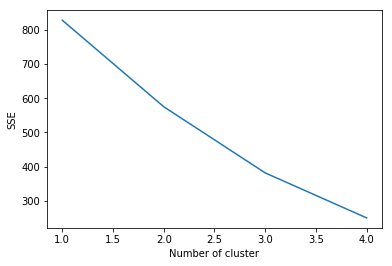

In [221]:
sse = {}
for k in range(1, 5):
    kmeans = KMeans(init="k-means++",n_clusters=k, n_init=12).fit(cluster_dataset)
    #full_data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


In [222]:
k = 3

k_means = KMeans(init="k-means++", n_clusters=k, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_
full_data['Labels'] = labels


In [223]:
full_data.groupby(by='Labels').mean()

,LATITUDE,LONGITUDE,NUMBER_OF_ROUTES,BIKE_CAPACITY,Cages,Hoops,Locker,Other,Parkiteer,PARKING_CAPACITY,...,ACCESS_WALK,PURPOSE_EDU,PURPOSE_NIL,PURPOSE_APTMNT,PURPOSE_SOCIAL,PURPOSE_TOURIST,PURPOSE_VISIT,PURPOSE_WORK,venues,DB_LABEL
Labels,,,,,,,,,,,,,,,,,,,,,
0,-37.838603,145.029412,1.566176,3.345588,0.007353,0.073529,1.830882,0.022059,0.066176,80.176471,...,0.634559,0.176765,0.015588,0.068456,0.101250,0.004926,0.055441,0.570441,7.102941,0.0
1,-37.833134,145.063134,1.253731,31.746269,0.134328,0.701493,5.641791,0.059701,0.761194,437.194030,...,0.356269,0.234030,0.013731,0.058060,0.084776,0.003433,0.045075,0.515224,7.014925,0.0
2,-37.815000,144.962500,15.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.710000,0.167500,0.017500,0.055000,0.070000,0.010000,0.052500,0.635000,39.750000,0.0


In [224]:
import folium

In [225]:
m = folium.Map(location=[-37.8136, 144.9631])

In [226]:
markers_colors = ['blue', 'yellow', 'red', 'green','orange', 'purple']
for lat, lon, poi, cluster in zip(full_data['LATITUDE'], full_data['LONGITUDE'], full_data['STATION_NAME'], full_data['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=markers_colors[cluster],
        fill=True,
        fill_color=markers_colors[cluster],
        fill_opacity=0.7).add_to(m)

In [227]:
m

In [228]:
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 

In [241]:
epsilon = 0.5
minimumSamples = 3
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X)
labels = db.labels_
full_data['DB_LABEL'] = labels+1

In [242]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask

array([False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,

In [243]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

2

In [244]:
m2 = folium.Map(location=[-37.8136, 144.9631])
markers_colors = ['blue', 'yellow', 'red', 'green','orange', 'purple']
for lat, lon, poi, cluster in zip(full_data['LATITUDE'], full_data['LONGITUDE'], full_data['STATION_NAME'], full_data['DB_LABEL']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=markers_colors[cluster],
        fill=True,
        fill_color=markers_colors[cluster],
        fill_opacity=0.7).add_to(m2)

In [245]:
m2

In [237]:
full_data.groupby(by='DB_LABEL').mean()[['NUMBER_OF_ROUTES',
       'BIKE_CAPACITY', 'PARKING_CAPACITY', 'ANNUAL_PATRONAGE', 'venues']]

,NUMBER_OF_ROUTES,BIKE_CAPACITY,PARKING_CAPACITY,ANNUAL_PATRONAGE,venues
DB_LABEL,,,,,
0,1.740541,13.956757,217.275676,1.106865,8.524324
1,1.300000,0.000000,0.000000,0.292000,0.000000
2,1.888889,0.000000,0.000000,0.621111,1.000000
3,2.333333,0.000000,0.000000,0.570000,3.000000


In [238]:
cluster_2 = full_data.loc[full_data.DB_LABEL == 2]


In [239]:
cluster_2[['STATION_NAME','NUMBER_OF_ROUTES',
       'BIKE_CAPACITY','ANNUAL_PATRONAGE', 'PRE_PEAK', 'AM_PEAK',
       'INTERPEAK', 'PM_PEAK', 'POST_PEAK', 'WEEKDAY_ENTRIES', 'SAT_ENTRIES',
       'SUN_ENTRIES', 'AVG_WEEKLY_ENTRIES','venues']]

,STATION_NAME,NUMBER_OF_ROUTES,BIKE_CAPACITY,ANNUAL_PATRONAGE,PRE_PEAK,AM_PEAK,INTERPEAK,PM_PEAK,POST_PEAK,WEEKDAY_ENTRIES,SAT_ENTRIES,SUN_ENTRIES,AVG_WEEKLY_ENTRIES,venues
STATION_CODE,,,,,,,,,,,,,,
UPW,upwey,1.0,0.0,0.15,74.65,246.95,114.62,98.22,15.55,550.0,230.0,140.0,3120.0,1
HEY,heyington,1.0,0.0,0.21,12.85,215.95,161.16,444.84,25.20,860.0,220.0,130.0,4650.0,1
HUG,hughesdale,2.0,0.0,0.55,102.23,926.22,417.64,339.67,84.24,1870.0,990.0,680.0,11020.0,1
CNE,carnegie,2.0,0.0,0.95,176.35,1521.97,747.48,474.01,220.20,3140.0,1960.0,1360.0,19020.0,1
EGT,eaglemont,1.0,0.0,0.18,43.84,389.63,133.89,56.20,16.44,640.0,290.0,180.0,3670.0,1
GVE,gardenvale,1.0,0.0,0.47,62.42,857.01,342.84,335.45,72.28,1670.0,810.0,500.0,9660.0,1
WIN,windsor,1.0,0.0,1.05,140.97,1521.38,682.51,1027.47,317.68,3690.0,1920.0,1220.0,21590.0,1
NME,north melbourne,6.0,0.0,1.48,90.59,681.08,1077.17,2832.33,388.83,5070.0,2570.0,1810.0,29730.0,1
KEN,kensington,2.0,0.0,0.55,95.04,912.93,414.89,330.77,86.36,1840.0,1120.0,740.0,11060.0,1
